# We created a $10 \times 10$ topology raster with Grass GIS Geomorphon algorithm
- Need to append this to our dataframe
- Raster has three layers
1. Height
2. Topology
3. Slope
- Raster has shape [< product >, < row >, < column >]
- Raster is in crs SWEREF99 TM (EPSG:3006)
- Dataset is in WGS84 / UTM33N (EPSG:32633)

In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
import matplotlib.pyplot as plt
import re
%matplotlib inline

In [3]:
#Setting up paths
SELECTED_YEARS = [2017,2018,2019,2020]
TOPOLOGY_RASTER_PATH = '/mimer/NOBACKUP/groups/snic2022-23-428/shared_oliver_christoffer/topology_raster.tif'
WEATHER_AUGMENTED_DATASETS = {year: f'/mimer/NOBACKUP/groups/snic2022-23-428/shared_oliver_christoffer/raw_data_12m/weather_augmented/grid_12m_{year}_weather_augmented.json' for year in SELECTED_YEARS}
WEATHER_TOPOLOGY_AUGMENTED_DATASETS = {year: f'/mimer/NOBACKUP/groups/snic2022-23-428/shared_oliver_christoffer/raw_data_12m/weather_topology_augmented/hostvete_weather_topology_augmented_{year}.json' for year in SELECTED_YEARS}
#Constants for accessing raster layers in a civilized manner
HEIGHT = 0
TOPOLOGY = 1
SLOPE = 2

In [4]:
with rasterio.open(TOPOLOGY_RASTER_PATH) as f:
    raster_matrix = f.read()
    raster_bbox = f.bounds
    
raster_res_x = (raster_bbox.right - raster_bbox.left)/raster_matrix.shape[2]
raster_res_y = (raster_bbox.top - raster_bbox.bottom)/raster_matrix.shape[1]

In [5]:
raster_bbox

BoundingBox(left=362350.0, bottom=6161270.0, right=423230.0, top=6222590.0)

In [6]:
raster_matrix.shape

(3, 6132, 6088)

In [7]:
harvest_df = {year: gpd.read_file(WEATHER_AUGMENTED_DATASETS[year]) for year in SELECTED_YEARS}
harvest_df = {year: harvest_df[year].set_crs(epsg=32633, allow_override=True).to_crs(epsg=3006) for year in SELECTED_YEARS}

In [8]:
harvest_df[2017].crs

<Derived Projected CRS: EPSG:3006>
Name: SWEREF99 TM
Axis Info [cartesian]:
- N[north]: Northing (metre)
- E[east]: Easting (metre)
Area of Use:
- name: Sweden - onshore and offshore.
- bounds: (10.03, 54.96, 24.17, 69.07)
Coordinate Operation:
- name: SWEREF99 TM
- method: Transverse Mercator
Datum: SWEREF99
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

# Now harvest_dfs and raster has same CRS.
- Need to convert epsg:3006 coordinates to pixel coordinates
- Need to construct a 3x3 sample grid in pixel coordinates for each sample point in harvest df

In [9]:
def coord_to_pixel(lon, lat):
    x = np.floor((lon - raster_bbox.left)/raster_res_x).astype(int)
    y = np.floor((lat - raster_bbox.bottom)/raster_res_y).astype(int)
    return [x, y]

## Verify coordinate transformation

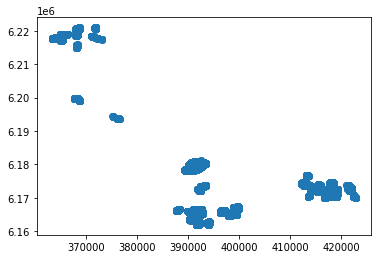

In [11]:
plt.scatter( harvest_df[2019].x.values, harvest_df[2019].y.values )

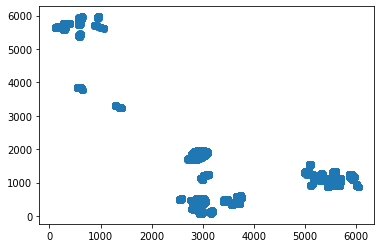

In [12]:
pixels = np.array([coord_to_pixel(x, y) for (x,y ) in zip(harvest_df[2019].x.values,harvest_df[2019].y.values)])
plt.scatter(pixels[:,0],pixels[:,1])

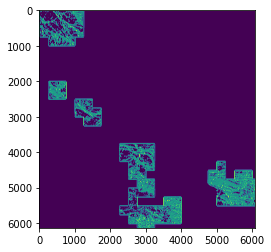

In [13]:
plt.imshow(raster_matrix[TOPOLOGY])

In [14]:
def onehot(n):
    v = np.zeros(10)
    v[n-1] = 1
    return v

## Coordinate transformation preserves geometry and is thus working
- Now we construct 3x3 sample grid given a point

In [15]:
displacement_grid = [
                        (0,0),   #C
                        (0,-1),  #N
                        (1,-1),  #NE
                        (1,0),   #E
                        (1,1),   #SE
                        (0,1),   #S
                        (-1,1),  #SW
                        (-1,0),  #W
                        (-1,-1)  #NW 
                    ]
neighbours_col_names = [
    "c",
    "n",
    "ne",
    "e",
    "se",
    "s",
    "sw",
    "w",
    "nw"
]

topology_classes = [
    "flat",
    "peak",
    "ridge",
    "shoulder",
    "spur",
    "slope",
    "hollow",
    "footslope",
    "valley",
    "pit"
]

#Setup column names
topology_col_names = []
for neighbour_name in neighbours_col_names:
    topology_col_names += [f'{neighbour_name}_{topology_name}' for topology_name in topology_classes]
    
int_top_col_names = [f'{neighbour_name}_inttopology' for neighbour_name in neighbours_col_names]
    
height_col_names = [f'{neighbour_name}_height' for neighbour_name in neighbours_col_names]

def is_inttopology(col):
    res = re.search('(\D+)_inttopology',col)
    if res is None:
        return False
    return res.groups()[0] in neighbours_col_names

['c_inttopology',
 'n_inttopology',
 'ne_inttopology',
 'e_inttopology',
 'se_inttopology',
 's_inttopology',
 'sw_inttopology',
 'w_inttopology',
 'nw_inttopology']

In [17]:
for year in SELECTED_YEARS:
    sample_matrix = []
    for lon,lat in zip(harvest_df[year].x.values,harvest_df[year].y.values):
        #Construct sample grid
        x, y = coord_to_pixel(lon,lat)
        neighbour_grid = [[x+dx, y+dy] for dx, dy in displacement_grid]
        
        #Sample topology (onehot)
        row = []
        topology_samples = [raster_matrix[TOPOLOGY,-y,x].astype(int) for x,y in neighbour_grid]
        for neighbour_name, sample in zip(neighbours_col_names, topology_samples):
            sample = onehot(sample).astype(int)
            #n_col_names = [neighbour_name + '_' + top_name for top_name in topology_classes]
            row.append(sample)
        row = np.array(row).flatten()
        
        #Sample topology integer
        row = np.concatenate((row, np.array(topology_samples).astype(int)))
        
        #Sample height
        height_samples = np.array([raster_matrix[HEIGHT, -y, x] for x,y in neighbour_grid])
        row = np.concatenate((row, height_samples))
        
        #Add row to sample matrix
        sample_matrix.append( row )
    
    #Construct dataframes and save
    topology_height_df = pd.DataFrame(sample_matrix,columns=topology_col_names+int_top_col_names+height_col_names)
    augmented_df = pd.concat([harvest_df[year], topology_height_df], axis=1)
    augmented_df.to_file(WEATHER_TOPOLOGY_AUGMENTED_DATASETS[year])

In [31]:
int_cols = [col for col in topology_height_df.columns if is_inttopology(col)]
#topology_height_df.loc[:,int_cols]
augmented_df

,grid_id,soil_id,dist,year,ph,humus_percentage,clay_percentage,silt_percentage,sand_percentage,gravel_percentage,...,nw_inttopology,c_height,n_height,ne_height,e_height,se_height,s_height,sw_height,w_height,nw_height
0,371700_6220900,24041,170.146554,2011,7.0,5.1,56,NaN,NaN,NaN,...,4.0,18.521471,18.362307,18.407629,18.531670,18.697866,18.788319,18.837025,18.690945,18.458984
1,371750_6220950,24041,167.271785,2011,7.0,5.1,56,NaN,NaN,NaN,...,1.0,19.429607,19.278936,19.352554,19.530685,19.684471,19.591898,19.513981,19.352201,19.216436
2,371750_6221000,24041,144.360140,2011,7.0,5.1,56,NaN,NaN,NaN,...,1.0,20.161995,20.016502,20.067633,20.182205,20.283680,20.282207,20.251272,20.171593,20.021811
3,371800_6221000,24041,192.379443,2011,7.0,5.1,56,NaN,NaN,NaN,...,1.0,20.246496,20.161198,20.121088,20.186991,20.284863,20.363087,20.416473,20.307884,20.200266
4,371800_6221050,24041,186.734705,2011,7.0,5.1,56,NaN,NaN,NaN,...,4.0,20.294668,20.438026,20.239319,20.050453,19.801388,20.061443,20.270542,20.453358,20.523060
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3773,422600_6172500,95149,43.391496,2011,6.8,0.0,0,NaN,0.0,NaN,...,4.0,91.934334,92.423714,92.055771,91.530739,90.181015,90.499397,90.819649,92.246994,92.717346
3774,422600_6172550,95148,7.015379,2011,7.1,3.6,28,NaN,34.0,NaN,...,6.0,88.414894,88.951820,88.800217,88.273911,87.869843,88.028221,88.197678,88.571571,89.109001
3775,422600_6172750,87960,48.996735,2011,6.9,3.6,27,NaN,NaN,NaN,...,3.0,89.959702,90.222824,90.279839,90.019829,89.654030,89.665443,89.589996,89.930786,90.130920
3776,422600_6172800,87960,8.982205,2011,6.9,3.6,27,NaN,NaN,NaN,...,6.0,87.573318,88.094490,88.102715,87.567734,87.206566,87.212852,87.145874,87.490692,87.974274


In [18]:
df = gpd.read_file(WEATHER_TOPOLOGY_AUGMENTED_DATASETS[2017])

In [35]:
df

,c_inttopology,n_inttopology,ne_inttopology,e_inttopology,se_inttopology,s_inttopology,sw_inttopology,w_inttopology,nw_inttopology
0,1.0,1.0,1.0,1.0,1.0,1.0,4.0,4.0,4.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,4.0,4.0,1.0,4.0,1.0,4.0,4.0,4.0,4.0
...,...,...,...,...,...,...,...,...,...
3773,6.0,5.0,6.0,6.0,6.0,6.0,6.0,5.0,4.0
3774,6.0,6.0,6.0,6.0,7.0,7.0,7.0,6.0,6.0
3775,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
3776,9.0,5.0,6.0,9.0,9.0,9.0,9.0,9.0,6.0


In [58]:
def is_height(col):
    res = re.search(r'(\D+)_height', col)
    if res == None:
        return False
    return res.groups()[0] in neighbours_col_names

[col for col in df.columns.values if is_height(col)]

['c_height',
 'n_height',
 'ne_height',
 'e_height',
 'se_height',
 's_height',
 'sw_height',
 'w_height',
 'nw_height']